In [104]:
import os  
import numpy as np 
import pandas as pd 
import seaborn as sn
import keras
import matplotlib.pyplot as plt
from keras.datasets import cifar100
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers    
from keras.utils import to_categorical
from keras import optimizers


In [105]:
# veri önce karıştırılıyor (shuffle) sonra da eğitim/test diye ayrılıyor
# Veri karıştırılır ve train-test şeklinde bölünüyor

(x_train,y_train),(x_test,y_test) = cifar100.load_data() 

In [106]:
# ödev için belirlenen sınıflarımızı Cifar100 veri seti içinden 'siniflarim' isminde değişkenin içine ayırıp yerleştiriyoruz

siniflarim = dict({0:"apple",3:"bear",44:"lizard",59:"pine_tree",89:"tractor",91:"trout"})

In [107]:
def save_resimler(x,y,siniflar,dosya_yol):
    for i,j in siniflar.items():
        sinif_yol = os.path.join(dosya_yol, j)
        os.mkdir(sinif_yol)
        resimler = x[y[:,0] == i]
        for k,resim in enumerate(resimler):
            plt.imsave(sinif_yol +"\\"+ str(k)+".png",resim)   

In [108]:
veriseti_path = "cifar100_siniflar"

os.mkdir(veriseti_path)

train_dir = os.path.join(veriseti_path, 'train')
os.mkdir(train_dir)
test_dir = os.path.join(veriseti_path, 'test')
os.mkdir(test_dir)

save_resimler(x_train,y_train,siniflarim,train_dir)
save_resimler(x_test,y_test,siniflarim,test_dir)

FileExistsError: [WinError 183] Halen varolan bir dosya oluşturulamaz: 'cifar100_siniflar'

In [ ]:
# plt olarak import ettiğimiz matplotlib.pyplot kütüphane ile eğitim için kullandığımız sınıfların örnek görüntüsünü alıyoruz

fig,ax = plt.subplots(6,11,figsize=(16,9))

labels = list(siniflarim.keys())

for i in range(6):
    resimler = x_train[y_train[:,0] == labels[i]]
    ax[i,0].axis("off")
    ax[i,0].text(0,0.5,siniflarim[labels[i]],fontdict={"size":14})
    for j in range(1,11):
        ax[i,j].axis("off")
        ax[i,j].imshow(resimler[j])
        
plt.show()

In [135]:
# Parametrelerin eğitilmesi :
epochs = 34                    # 30 epoch ile eğitim yapılacaktır.
batch_size = 50                # Her iterasyonda 50 fotoğraf alınır.
num_classes = len(siniflarim) # veri setinde 6  sınıf bulunmaktaonu len fonksiyon ile alıyoruz.
num_cel = x_train.shape[3]
width = x_train.shape[1]
height = x_train.shape[2]
 
# Modelin kaydedileceği yer belirlenir
save_dir = os.path.join(os.getcwd(), 'saved_models') 

# Kaydedilecek modelin dosya adı belirlenir
model_name = 'keras_6_classes_from_cifar100_trained_model.h5' 

In [136]:
#Verinin kesirli hale getirilip normalleştirilmesi
x_test = y_test.astype('float32') / 255
y_test = y_test.astype('float32') / 255

In [111]:
# Modelin temelinin oluşturulması : (dropout=False)
def make_model(dropout=False):
    model = models.Sequential() 
    
    # 32 adet 3x3 boyutunda filtereler oluşturulur ve modele eklenir
    # "Padding" fotoğrafa çervçeve ekler ve çıkış boyutunun giriş boyutuna eşit olması sağlanır
    # ReLu aktivasyon fonksiyonumuzu eklenir
    
    model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu",
                            input_shape=(width,height,num_cel)))
    # 32 adet 3x3 boyutunda filterelerden oluşan katmanımızı modelimize ekliyoruz
    model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu"))
    
    #1. evrişimden sonra max poolig metodunu kullanmaktadır.max pooling ile doğruluk oranı 87%'ye kadar çıkıyor.
    # 2x2 boyutunda çerçeveden oluşan MaxPooling katmanımızı ekliyoruz: 16 x 16 x 3
    model.add(layers.MaxPooling2D()) 
    
    # 64 adet 3x3 boyutunda filterelerden oluşan katmanımızı modelimize ekliyoruz
    model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    
    # 2x2 boyutunda çerçeveden oluşan MaxPooling katmanımızı ekliyoruz: 8 x 8 x 3
    model.add(layers.MaxPooling2D()) 
    
    # 128 adet 3x3 boyutunda filterelerden oluşan katmanımızı modelimize ekliyoruz
    # Cifar10 veri setinin resimleri max pool metodunu kullanmak için çok küçük(32x32). Bu nedenle:
    # pool_size=3, strides=2, padding='same' yapıyoruz
    model.add(layers.Conv2D(128,(3,3),padding="same",activation="relu"))
    model.add(layers.Conv2D(128,(3,3),padding="same",activation="relu"))
    
    # 2x2 boyutunda çerçeveden oluşan MaxPooling katmanımızı ekliyoruz: 4 x 4 x 3
    model.add(layers.MaxPooling2D()) 
    
    # 2 boyutlu görsellerimizi 1 boyutlu vektöre çeviriyoruz
    model.add(layers.Flatten())
        
    # 256 nöronumuzu modelimize ve ReLu aktivasyon fonksiyonumuzu ekliyoruz
    model.add(layers.Dense(256,activation="relu"))
    
    # 6 sınıfımızı temsil edecek 6 nöronumuzu modelimize ekliyoruz:(sinif_sayisi= 6)
    # Çıkış katmanına Sınıfların olasılıklarını hesaplamak için :
    # sınıf sayısı kadar "Softmax" aktivasyonlu nöron fonksiyonumuzu ekliyoruz
    model.add(layers.Dense(num_classes,activation="softmax"))
    
    # Modeli eğitirken kullanacağımız optimizasyon ve hata hesaplama fonksiyonumuzu belirliyoruz
    # "RMSprop" optimizasyon fonksiyonumuzu hazırlıyoruz: (lr=0.0001, decay=1e-6)
    # Sınıflandırma yapacağımız için "categorical_crossentropy" fonksiyonunu kullanıyoruz
    opt = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=opt,
                  loss="categorical_crossentropy",metrics=["acc"])
    model.summary()
    
    return model

In [145]:
 # Dropout uygulanacak ise: (dropout=True)
def make_model_2(Dropout=True):
    model = models.Sequential()
    model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu",
                            input_shape=(width,height,num_cel)))
    model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu"))
    model.add(layers.MaxPooling2D()) 
    # Rastgele olacak şekilde nöronların %25'ini kapatıyoruz: (Eğitim sırasındaki ezberlemeyi önlemek için.)
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    model.add(layers.MaxPooling2D()) 
    # Rastgele olacak şekilde nöronların %25'ini kapatıyoruz: (Eğitim sırasındaki ezberlemeyi önlemek için.)
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128,(3,3),padding="same",activation="relu"))
    model.add(layers.Conv2D(128,(3,3),padding="same",activation="relu"))
    model.add(layers.MaxPooling2D())  
    model.add(layers.Flatten())
    # Rastgele olacak şekilde nöronların %50'ini kapatıyoruz: (Eğitim sırasındaki ezberlemeyi önlemek için)
    model.add(layers.Dropout(0.50))
    # 256 nöronumuzu modelimize ve ReLu aktivasyon fonksiyonumuzu ekliyoruz
    model.add(layers.Dense(256,activation="relu"))
    model.add(layers.Dense(num_classes,activation="softmax"))
    # "Adam" optimizasyon fonksiyonumuzu hazırlıyoruz: Adam(lr=0.0001)
    opt = keras.optimizers.Adam(lr=0.0001)
    # Sınıflandırma yapacağımız için "categorical_crossentropy" fonksiyonunu kullanıyoruz
    model.summary()   
    model.compile(optimizer=opt,
                  loss="categorical_crossentropy",metrics=["acc"])     
    return model

In [113]:
def make_generator(train_dir,test_dir,augmentation=False):
    
    # Veri çeşitliliğini artırmak için veri sentezi (data augmentation)
    # Ön işleme ve gerçek zamanlı veri arttırımının uygulanması yapılacak ise:
    
    if(augmentation):
        
        # Sentezlenmiş (döndürülmüş, ters çevrilmiş, yakınlaştırolmış vb.) resimler üretmek için ImageDataGenerator kullanıyorum  
        # Canlı veri arttırmak için ayarlarımalar:
         print('Using real-time data augmentation.')
        
        train_datagen = image.ImageDataGenerator(rescale=1./255,                                          
        featurewise_center=False,             # Giriş verilerinin prtalamasının 0'lanması
        samplewise_center=False,              # Herbir örnek verinin ortalamasının 0'a eşitlenmesi
        featurewise_std_normalization=False,  # Giriş verilerinin, veri setinin standart varyans değerine bölünmesi
        samplewise_std_normalization=False,   # Herbir verinin standart varyans değerine bölünmesi
        zca_whitening=False,                  # "ZCA whitening" metodunun uygulanması                 
        rotation_range=0,                     # Resimlerin bir sınır aralığında gelişi güzel döndürülmesi (degrees, 0 to 180)
        width_shift_range=0.1,                # Görüntüleri rasgele olarak yatay olarak kaydırılır
        height_shift_range=0.1,               # Görüntüleri rasgele olarak dikey olarak kaydırılır
        shear_range=0.15,                     # Görüntüleri üzerinde rasgele makaslama
        zoom_range=0.15,                      # Görüntüleri üzerinde rasgele yakınlaştırılıyor
        horizontal_flip=True,                 # Fotoğrafı yatay düzlemde rastgele çevirme.
        vertical_flip=False)                  # Resimlerin gelişigüzel bir şekilde dikey olarak çevirilmesi
        train_datagen = image.ImageDataGenerator(rescale=1./255,
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True)
        
    
    # Veri arttırma işlemi yapılmayacak ise: 
    
    else: 
        print('Not using data augmentation.')
        
        train_datagen = image.ImageDataGenerator(rescale=1./255)
     
    test_datagen = image.ImageDataGenerator(rescale=1/255.)
    
    # Fit the model on the batches generated by datagen.flow().
    # Sınıf vektörlerinin ikili sınıf matrislerine dönüştürülmesi (categorical)
    
    train_gen = train_datagen.flow_from_directory(train_dir,target_size=(width,height),
                                              class_mode="categorical",batch_size=batch_size)
    test_gen = test_datagen.flow_from_directory(test_dir,target_size=(width,height),
                                              class_mode="categorical",batch_size=batch_size)
    
    return train_gen,test_gen

In [10]:
def make_gorsel(history,suptitle):
    epoklar = range(1,len(history["loss"])+1)
    
    fig,axx = plt.subplots(1,2,figsize=(18,6))
    
    axx[0].plot(epoklar,history["loss"],label="Training Loss")
    axx[0].plot(epoklar,history["val_loss"],label="Validation Loss")
    axx[0].set_title("Loss Karşılaştırması")
    axx[0].set_xlabel("Epoklar")
    axx[0].set_ylabel("Loss Değerleri")
    axx[0].legend()
  
    axx[1].plot(epoklar,history["acc"],label="Training Accuracy")
    axx[1].plot(epoklar,history["val_acc"],label="Validation Accuracy")
    axx[1].set_title("Accuracy Karşılaştırması")
    axx[1].set_xlabel("Epoklar")
    axx[1].set_ylabel("Accuracy Değerleri")
    axx[1].legend()
    
    fig.suptitle(suptitle,fontsize=15,color="black")

    plt.show()

In [130]:
def make_gorsel_2(historyList,aciklamalar):
    epoklar = range(1,len(historyList[0]["loss"])+1)
    
    fig,axx = plt.subplots(1,2,figsize=(18,6))
    
    colors = ["yellow","blue","black"]
    
    for i,history in enumerate(historyList):
        axx[0].plot(epoklar,history["loss"],label="Training " + aciklamalar[i],linestyle="--",color=colors[i])
        axx[0].plot(epoklar,history["val_loss"],label="Validation " + aciklamalar[i],color=colors[i],alpha=0.8)
        
    axx[0].set_title("Loss Karşılaştırması")
    axx[0].set_xlabel("Epoklar")
    axx[0].set_ylabel("Loss Değerleri")
    axx[0].legend()
  
    for i,history in enumerate(historyList):
        axx[1].plot(epoklar,history["acc"],label="Training " + aciklamalar[i],linestyle="--",color=colors[i])
        axx[1].plot(epoklar,history["val_acc"],label="Validation " + aciklamalar[i],color=colors[i],alpha=0.8)
    axx[1].set_title("Accuracy Karşılaştırması")
    axx[1].set_xlabel("Epoklar")
    axx[1].set_ylabel("Accuracy Değerleri")
    axx[1].legend()
    
    fig.suptitle("-".join(aciklamalar) + " Karşılaştırılması",fontsize=15,color="red")

    plt.show()

In [114]:
# Eğitim ve test için : kayıp ve doğruluk
def make_gorsel_3(history):
    plt.figure(0)
    plt.plot(history.history['acc'],'yellow')
    plt.plot(history.history['val_acc'],'blue')
    plt.xticks(np.arange(0, 11, 2.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['train','validation'])
    plt.figure(1)
    plt.plot(history.history['loss'],'yellow')
    plt.plot(history.history['val_loss'],'blue')
    plt.xticks(np.arange(0, 11, 2.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.legend(['train','validation'])
    
    

In [115]:
train_gen,test_gen = make_generator(train_dir,test_dir)

Not using data augmentation.
Found 3000 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [134]:
model = make_model(dropout=False)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 8, 128)        

In [137]:
#Dropout ve Veri Augmentation yapılmadan modelimizi eğitiyoruz

Normal_history = model.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,
                              epochs=epochs,validation_data=test_gen,validation_steps=test_gen.samples//batch_size)

Epoch 1/34
60/60 [==============================] - 285s 5s/step - loss: 1.6911 - acc: 0.3253 - val_loss: 1.5568 - val_acc: 0.3917
Epoch 2/34
60/60 [==============================] - 324s 5s/step - loss: 1.2927 - acc: 0.5070 - val_loss: 1.1545 - val_acc: 0.5400
Epoch 3/34
60/60 [==============================] - 261s 4s/step - loss: 1.1478 - acc: 0.5563 - val_loss: 0.9824 - val_acc: 0.5650
Epoch 4/34
60/60 [==============================] - 227s 4s/step - loss: 1.0559 - acc: 0.6170 - val_loss: 0.7423 - val_acc: 0.6217
Epoch 5/34
60/60 [==============================] - 224s 4s/step - loss: 0.9899 - acc: 0.6333 - val_loss: 0.8583 - val_acc: 0.6800
Epoch 6/34
60/60 [==============================] - 223s 4s/step - loss: 0.9054 - acc: 0.6653 - val_loss: 0.8963 - val_acc: 0.6483
Epoch 7/34
60/60 [==============================] - 223s 4s/step - loss: 0.8672 - acc: 0.6857 - val_loss: 0.8311 - val_acc: 0.7033
Epoch 8/34
60/60 [==============================] - 224s 4s/step - loss: 0.8043 - a

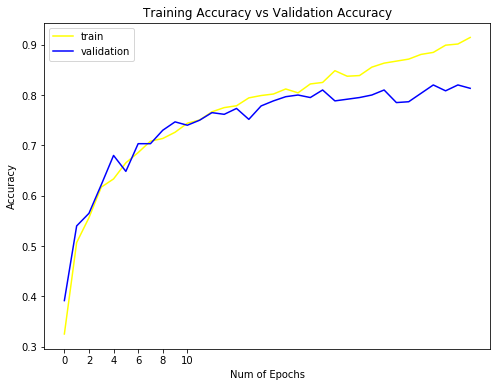

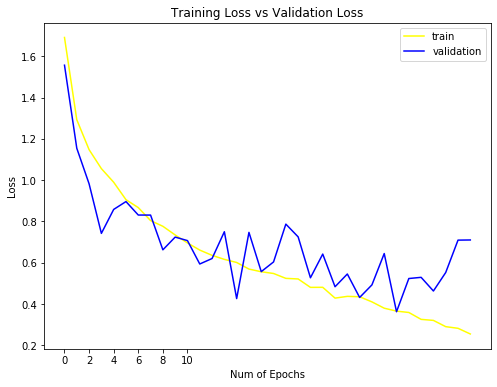

In [142]:
make_gorsel_3(Normal_history)

In [147]:
model = make_model_2(Dropout=True)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 8, 8, 64)        

In [148]:
# Canlı olarak arttırılan veri ile modelimizi eğitelim:

Dropout_history = model.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,
                              epochs=epochs,validation_data=test_gen,validation_steps=test_gen.samples//batch_size)

Epoch 1/34
60/60 [==============================] - 250s 4s/step - loss: 1.7810 - acc: 0.1900 - val_loss: 1.7557 - val_acc: 0.2633
Epoch 2/34
60/60 [==============================] - 244s 4s/step - loss: 1.5903 - acc: 0.3560 - val_loss: 1.5037 - val_acc: 0.4500
Epoch 3/34
60/60 [==============================] - 245s 4s/step - loss: 1.3157 - acc: 0.4743 - val_loss: 1.1853 - val_acc: 0.4917
Epoch 4/34
60/60 [==============================] - 245s 4s/step - loss: 1.2332 - acc: 0.5113 - val_loss: 1.1089 - val_acc: 0.5417
Epoch 5/34
60/60 [==============================] - 261s 4s/step - loss: 1.1916 - acc: 0.5367 - val_loss: 1.2609 - val_acc: 0.5467
Epoch 6/34
60/60 [==============================] - 254s 4s/step - loss: 1.1502 - acc: 0.5533 - val_loss: 0.8813 - val_acc: 0.5683
Epoch 7/34
60/60 [==============================] - 244s 4s/step - loss: 1.1252 - acc: 0.5703 - val_loss: 1.0604 - val_acc: 0.6050
Epoch 8/34
60/60 [==============================] - 247s 4s/step - loss: 1.0784 - a

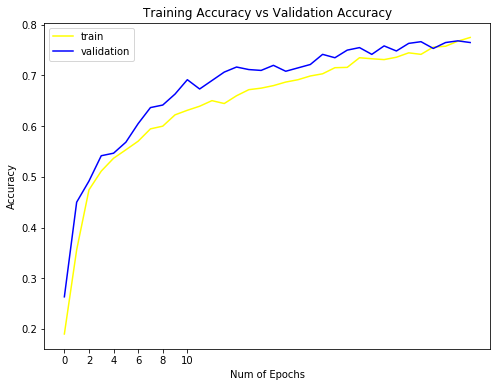

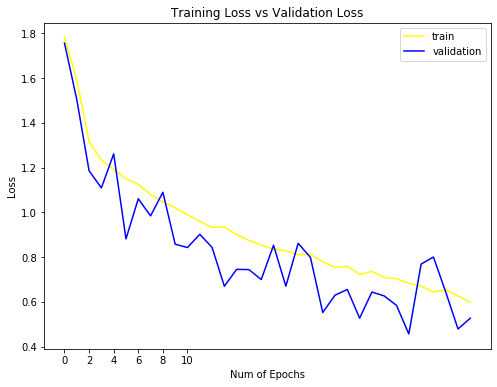

In [149]:
make_gorsel_3(Dropout_history)

In [153]:
model = make_model(dropout=False)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 8, 8, 128)       

In [154]:
train_gen,test_gen = make_generator(train_dir,test_dir,augmentation=True)

Using real-time data augmentation.
Found 3000 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [155]:
Augmentation_history = model.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,
                              epochs=epochs,validation_data=test_gen,validation_steps=test_gen.samples//batch_size)

Epoch 1/34
60/60 [==============================] - 357s 6s/step - loss: 1.7400 - acc: 0.2643 - val_loss: 1.5074 - val_acc: 0.4050
Epoch 2/34
60/60 [==============================] - 379s 6s/step - loss: 1.4485 - acc: 0.4200 - val_loss: 1.4244 - val_acc: 0.4800
Epoch 3/34
60/60 [==============================] - 504s 8s/step - loss: 1.2902 - acc: 0.4967 - val_loss: 1.3004 - val_acc: 0.5833
Epoch 4/34
60/60 [==============================] - 654s 11s/step - loss: 1.2015 - acc: 0.5297 - val_loss: 0.8927 - val_acc: 0.6017
Epoch 5/34
60/60 [==============================] - 423s 7s/step - loss: 1.1765 - acc: 0.5363 - val_loss: 0.9113 - val_acc: 0.6250
Epoch 6/34
60/60 [==============================] - 338s 6s/step - loss: 1.1178 - acc: 0.5773 - val_loss: 0.8844 - val_acc: 0.6400
Epoch 7/34
60/60 [==============================] - 336s 6s/step - loss: 1.0738 - acc: 0.5920 - val_loss: 0.8249 - val_acc: 0.6917
Epoch 8/34
60/60 [==============================] - 298s 5s/step - loss: 1.0568 - 

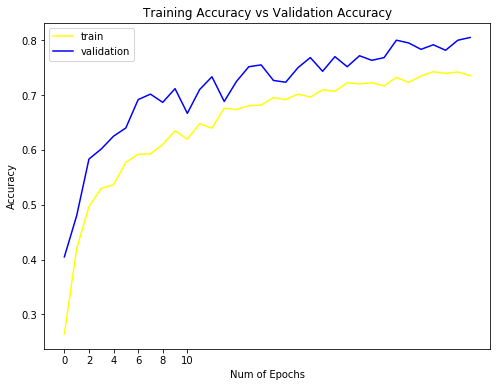

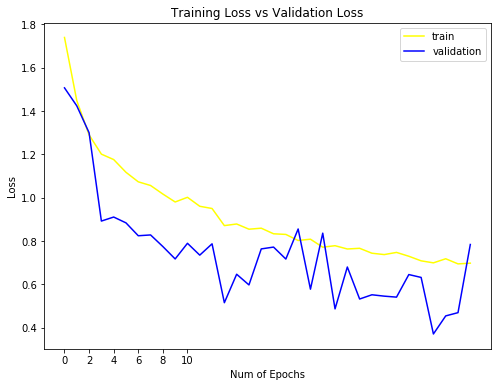

In [156]:
make_gorsel_3(Augmentation_history)

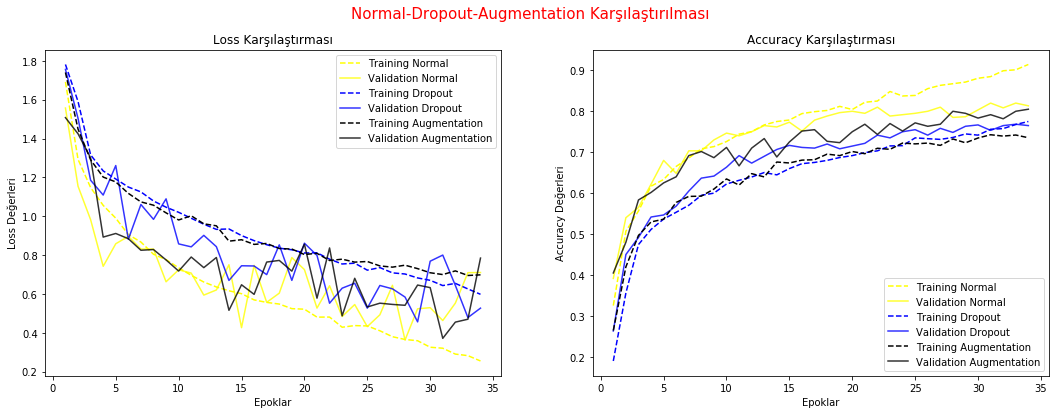

In [158]:
History_listesi = [Normal_history.history,Dropout_history.history,Augmentation_history.history]
Historiler = ["Normal","Dropout","Augmentation"]
make_gorsel_2(History_listesi,Historiler)

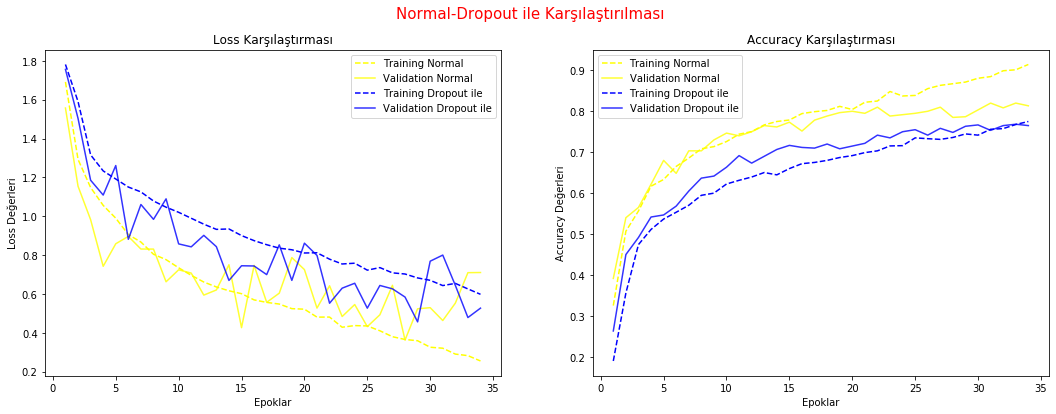

In [159]:
History_listesi = [Normal_history.history,Dropout_history.history]
Historiler = ["Normal","Dropout ile",]
make_gorsel_2(History_listesi,Historiler)

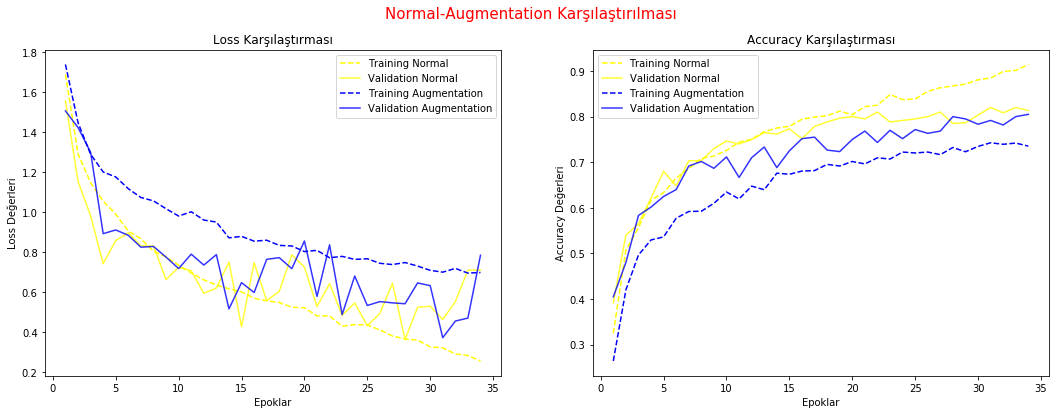

In [161]:
History_listesi = [Normal_history.history,Augmentation_history.history]
Historiler = ["Normal","Augmentation"]
make_gorsel_2(History_listesi,Historiler)

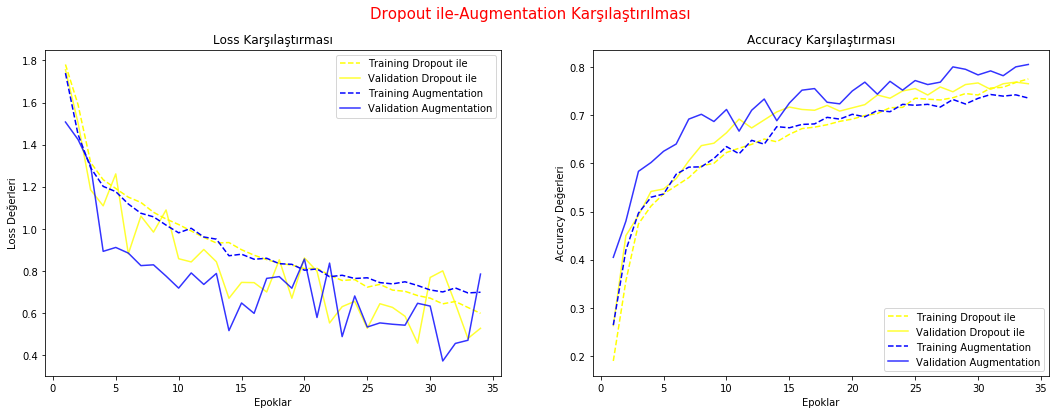

In [162]:
History_listesi = [Dropout_history.history,Augmentation_history.history]
Historiler  = ["Dropout ile","Augmentation"]
make_gorsel_2(History_listesi,Historiler )

In [163]:
MaxTrainAccuracy = [np.max(historyNormal.history["acc"]),
          np.max(Dropout_history.history["acc"]),
          np.max(Augmentation_history.history["acc"])]

MaxValidationAccuracy = [np.max(historyNormal.history["val_acc"]),
          np.max(Dropout_history.history["val_acc"]),
          np.max(Augmentation_history.history["val_acc"])]

x = np.arange(len(MaxTrainAccuracy))

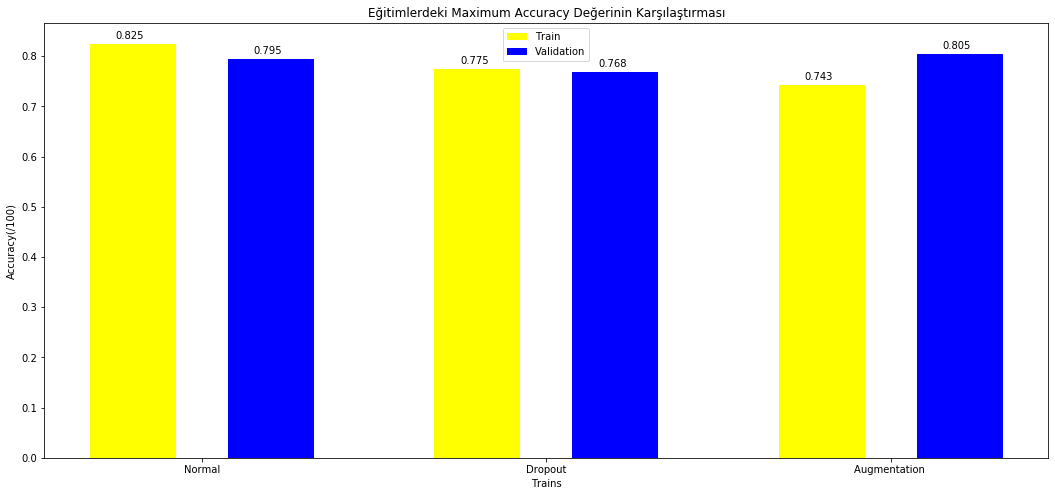

In [171]:
plt.figure(figsize=(18,8))

a = x-0.2
b = x+0.2
plt.bar(a,MaxTrainAccuracy,width=0.25,color="yellow")
plt.bar(b,MaxValidationAccuracy,width=0.25,color="blue")

plt.xlabel("Trains")
plt.xticks(x,["Normal","Dropout","Augmentation "])
plt.ylabel("Accuracy(/100)")
plt.title("Eğitimlerdeki Maximum Accuracy Değerinin Karşılaştırması")

plt.legend(["Train","Validation"])

for i in range(len(x)):
    plt.text(a[i]-0.05,MaxTrainAccuracy[i]+0.01,str("{:.3f}".format(MaxTrainAccuracy[i])))
    plt.text(b[i]-0.05,MaxValidationAccuracy[i]+0.01,str("{:.3f}".format(MaxValidationAccuracy[i])))
    
plt.show()